In [1]:
# Display plots in the notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Common imports
import numpy as np
import pylab as pl
import pandas as pd
import geopandas as gp
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

In [3]:
# Make plots prettyful
pl.style.use('fivethirtyeight')

In [5]:
masterroutes = pd.read_csv('../data/vanroutes3-11_430pm.csv')

In [6]:
masterroutes.describe()

,FID,FID_1,CTLabel,BoroCode,CT2010,BoroCT2010,PUMA,Shape_Leng,Shape_Area,Count_,Sum_Id,IsDestination?,FlatbushDest,ChinaDest,JamicaDest,OriginChina,DONOTUSE,OriginFlat,DoNotUse,OriginJamica
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2.166000e+03,2166.000000,2166,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,1082.500000,1082.500000,417.508306,2.988458,41750.830563,3030208.817636,3959.597876,8727.808140,3.891989e+06,0.085411,0,0.085411,0.034164,0.035088,0.007849,0.035088,0.000190,0.058172,0.000139,0.034626
std,625.414662,625.414662,398.471002,1.096438,39847.100208,1108559.417556,145.132942,8523.532259,7.965884e+06,0.279557,0,0.279557,0.181693,0.184044,0.088264,0.184044,0.000764,0.234122,0.000755,0.182873
min,0.000000,0.000000,1.000000,1.000000,100.000000,1000100.000000,3701.000000,168.524338,5.819571e+02,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,541.250000,541.250000,155.250000,2.000000,15525.000000,2036325.000000,3808.000000,5622.626332,1.683579e+06,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1082.500000,1082.500000,302.500000,3.000000,30250.000000,3053050.000000,4009.000000,6504.164467,1.988041e+06,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1623.750000,1623.750000,581.750000,4.000000,58175.000000,4034500.000000,4103.000000,8740.198062,3.178574e+06,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2165.000000,2165.000000,9901.000000,5.000000,990100.000000,5990100.000000,4114.000000,186126.742200,1.962345e+08,1.000000,0,1.000000,1.000000,1.000000,1.000000,1.000000,0.003265,1.000000,0.004368,1.000000


In [7]:
# Pull in data
demographics = pd.read_excel('../data/DemoData.xlsx')
demographics['tract'] = demographics.ID.astype(str).str.zfill(9)

shp = gp.GeoDataFrame.from_file('../data/merged.json')

shp = shp.merge(demographics, on='tract')

shp.rename(columns={
#    'Destination?': 'is_dest',
    'Origin?': 'is_orig',
    'Total Population': 'pop',
    '18 to 24 yrs': '_18_to_24',
    '65 and Above': 'above_65',
    'Median Age': 'age',
    'Non-white': 'nonwhite',
    'English less than "very well"': 'nonenglish',
    'Annaul Individual Income below 10000': 'income_below_10000',
    'Annaul Individual Income below 15000': 'income_below_15000',
    'Median Income': 'income',
    'Below 100 percent of the poverty level': 'below_pov',
    '100 to 149 percent of the poverty level': '_100_149_pov',
    'At or above 150 percent of the poverty level': 'above_150_pov',
    'Citizenship status': 'noncitizen',
    'Place of Birth': 'foreignborn'
}, inplace=True)

lehd = pd.read_csv('../data/merged.csv', dtype={'tract': str})

lehd = lehd.drop([u'Unnamed: 0', u'Both', u'Destination?', u'DollarVanLine', u'Origin?',
       u'average_commute_time', u'average_walk_distance', u'geometry',
       u'number_of_commuters',  u'w_county_tract', u'h_county_tract'], 1)

shp = shp.merge(lehd, on='tract')

routes = pd.read_csv('../data/vanroutes3-11_430pm.csv', dtype={'BoroCT2010': str, 'BoroCode': str})

#routes['BoroCode'] = routes.BoroCT2010.str[0]

routes['county_code'] = ""
routes['county_code'][routes['BoroCode'] == '1'] = '061' # Manhattan
routes['county_code'][routes['BoroCode'] == '2'] = '005' # Bronx
routes['county_code'][routes['BoroCode'] == '3'] = '047' # Brooklyn
routes['county_code'][routes['BoroCode'] == '4'] = '081' # Queens
routes['county_code'][routes['BoroCode'] == '5'] = '085' # Staten Island

routes['tract'] = routes['county_code'] + routes['BoroCT2010'].str[1:]

#routes['is_dest'] = routes['Count_']
#routes['is_dest'][routes['BUFF_DIST'] == .5] = 1

shp = shp.merge(routes[['tract', 'FlatbushDest', 'ChinaDest', 'JamicaDest', 'OriginFlat', 'OriginChina', 'OriginJamica']], on='tract')

# Standardize Value Range
for c in [
        u'average_commute_time', u'average_walk_distance',
        u'number_of_commuters',u'pop',
                       u'_18_to_24',                    u'above_65',
                         u'age',             u'nonwhite',
                  u'nonenglish',    u'income_below_10000',
          u'income_below_15000',                u'income',
                   u'below_pov',           u'_100_149_pov',
               u'above_150_pov',            u'noncitizen',
                 u'foreignborn',
    u'wac_total_jobs',
              u'wac_jobs_lt_29',        u'wac_jobs_30_54',
              u'wac_jobs_gt_55',      u'wac_minc_lt_1250',
          u'wac_minc_1251_3333',      u'wac_minc_gt_3333',
              u'rac_total_jobs',        u'rac_jobs_lt_29',
              u'rac_jobs_30_54',        u'rac_jobs_gt_55',
            u'rac_minc_lt_1250',    u'rac_minc_1251_3333',
            u'rac_minc_gt_3333'
]:
    shp[c] = ((shp[c] - shp[c].mean())/shp[c].std())
    
shp = shp.dropna()

ERROR:Fiona:CPLE_OpenFailed in Unable to open EPSG support file gcs.csv.
Try setting the GDAL_DATA environment variable to point to the
directory containing EPSG csv files.
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\Users\docmario\Anaconda2\lib\site-packages\ipykernel\__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.

In [8]:
shp

,Both,Destination?,DollarVanLine,is_orig,average_commute_time,average_walk_distance,geometry,id,number_of_commuters,tract,...,rac_jobs_gt_55,rac_minc_lt_1250,rac_minc_1251_3333,rac_minc_gt_3333,FlatbushDest,ChinaDest,JamicaDest,OriginFlat,OriginChina,OriginJamica
0,0,0,1,1,-1.058380,-0.683937,"POLYGON ((988504.1384277344 198118.3380126953,...",0,0.207354,061000201,...,-0.703167,0.024983,-0.362521,-0.567460,0,1,0,0,1,0
1,0,0,1,1,-1.471869,-1.405481,"(POLYGON ((989149.298828125 196328.6047973633,...",1,1.683974,061000202,...,1.824599,1.746437,1.143693,0.807462,0,0,0,0,0,0
2,1,1,1,1,-1.676703,-1.549415,"POLYGON ((987978.8082275391 197698.2456054688,...",2,2.794107,061000600,...,2.047477,4.249440,2.688627,0.933989,0,1,0,0,1,0
3,0,0,0,0,-1.849505,-1.684508,(POLYGON ((984943.4877929688 194173.7781982422...,3,4.911697,061000700,...,0.590614,0.045416,-0.087608,4.987900,0,0,0,0,0,0
4,1,1,1,1,-1.674524,-1.400408,"POLYGON ((986494.1445922852 197775.8300170898,...",4,2.326977,061000800,...,1.846343,4.372036,1.809679,0.503798,0,1,0,0,1,0
5,0,0,0,0,-1.543344,-1.267139,(POLYGON ((984175.4826049805 192471.2318115234...,5,0.744630,061000900,...,-0.839068,-0.971110,-1.311164,0.306417,0,0,0,0,0,0
6,0,0,1,1,-0.806713,-0.383431,"POLYGON ((991128.2537841797 199590.250793457, ...",6,-0.040190,061001001,...,-0.654242,-1.119247,-1.284060,-0.365017,0,0,0,0,0,0
7,0,0,1,1,-1.249107,-0.996808,"POLYGON ((990784.524230957 199725.3294067383, ...",7,0.983532,061001002,...,0.237271,1.271377,1.279213,-0.307659,0,0,0,0,0,0
8,0,0,1,1,-1.382843,-1.128628,"POLYGON ((989934.2239990234 199730.8380126953,...",8,0.778178,061001200,...,-0.072584,-0.215101,-0.459321,0.252432,0,0,0,0,0,0
9,0,0,0,0,-1.767690,-1.610795,"POLYGON ((980015.6190185547 196065.4348144531,...",9,2.743785,061001300,...,-0.159561,-0.317264,-0.505785,2.534971,0,0,0,0,0,0


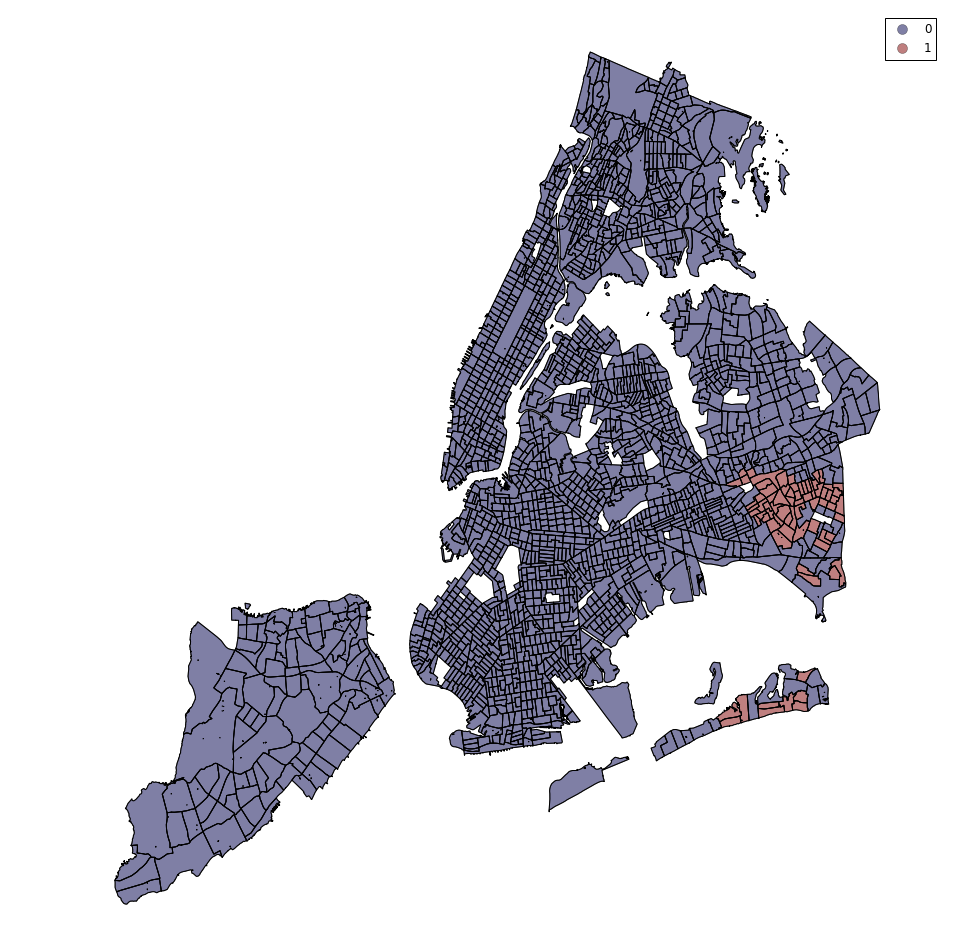

In [14]:
figure, ax = pl.subplots(figsize=(16,16))
ax.axis('off')
shp.plot(axes=ax, column='OriginJamica', legend=True, categorical=True, colormap='seismic') #prism, magma, winter
#ax.set_title('Actual and Predicted Dollar Van Destinations')

In [15]:
data = shp[[
    'average_commute_time', 
    'average_walk_distance',
    'number_of_commuters',
    'pop',
    '_18_to_24',
    'above_65',
    'age',
    'nonwhite',
    'nonenglish',
    'income_below_10000',
    'income_below_15000',
    'income',
    'below_pov',
    '_100_149_pov',
    'above_150_pov',
    'noncitizen',
    'foreignborn',
    'wac_total_jobs',
    'wac_jobs_lt_29',        
    'wac_jobs_30_54',
    'wac_jobs_gt_55', 
    'wac_minc_lt_1250',
    'wac_minc_1251_3333',      
    'wac_minc_gt_3333',
    'rac_total_jobs',
    'rac_jobs_lt_29',
    'rac_jobs_30_54',  
    'rac_jobs_gt_55',
    'rac_minc_lt_1250',    
    'rac_minc_1251_3333',
    'rac_minc_gt_3333'
]].values

In [34]:
cols = np.array([
    'average_commute_time', 
    'average_walk_distance',
    'number_of_commuters',
    'pop',
    '_18_to_24',
    'above_65',
    'age',
    'nonwhite',
    'nonenglish',
    'income_below_10000',
    'income_below_15000',
    'income',
    'below_pov',
    '_100_149_pov',
    'above_150_pov',
    'noncitizen',
    'foreignborn',
    'wac_total_jobs',
    'wac_jobs_lt_29',        
    'wac_jobs_30_54',
    'wac_jobs_gt_55', 
    'wac_minc_lt_1250',
    'wac_minc_1251_3333',      
    'wac_minc_gt_3333',
    'rac_total_jobs',
    'rac_jobs_lt_29',
    'rac_jobs_30_54',  
    'rac_jobs_gt_55',
    'rac_minc_lt_1250',    
    'rac_minc_1251_3333',
    'rac_minc_gt_3333'
])

In [16]:
shp.columns

Index([                 u'Both',          u'Destination?',
               u'DollarVanLine',               u'is_orig',
        u'average_commute_time', u'average_walk_distance',
                    u'geometry',                    u'id',
         u'number_of_commuters',                 u'tract',
                          u'ID',             u'Geography',
                         u'pop',             u'_18_to_24',
                    u'above_65',                   u'age',
                    u'nonwhite',            u'nonenglish',
          u'income_below_10000',    u'income_below_15000',
                      u'income',             u'below_pov',
                u'_100_149_pov',         u'above_150_pov',
                  u'noncitizen',           u'foreignborn',
              u'wac_total_jobs',        u'wac_jobs_lt_29',
              u'wac_jobs_30_54',        u'wac_jobs_gt_55',
            u'wac_minc_lt_1250',    u'wac_minc_1251_3333',
            u'wac_minc_gt_3333',        u'rac_total_jobs

In [53]:
for route in ['OriginChina', 'OriginFlat', 'OriginJamica', 'FlatbushDest', 'JamicaDest']:
    print "Features selected for %s" % route
    target = shp[route]
    C = .001
    while True:
        lsvc = LinearSVC(C=C, penalty="l1", dual=False).fit(data, target)
        model = SelectFromModel(lsvc, prefit=True)
        
        if model.get_support().sum() < 5:
            C += .001
            continue

        for i in cols[model.get_support()]:
            print "mean of", i, '=', shp[shp[route] == 1][i].mean()
            
        break
        
    print

Features selected for OriginChina
mean of average_commute_time = -0.518189433263
mean of age = 0.0999918018622
mean of nonenglish = 1.38142134339
mean of wac_minc_lt_1250 = 0.515220871986
mean of rac_minc_1251_3333 = 0.087163309386

Features selected for OriginFlat
mean of average_walk_distance = -0.221382068822
mean of nonwhite = 1.00581232596
mean of nonenglish = -0.579644152707
mean of income_below_15000 = -0.289939663912
mean of below_pov = -0.307335435507

Features selected for OriginJamica
mean of average_commute_time = 1.62816282592
mean of nonwhite = 1.16689594099
mean of nonenglish = -0.777766256642
mean of above_150_pov = 0.424154639281
mean of foreignborn = -0.525492101882

Features selected for FlatbushDest
mean of average_commute_time = -0.283247629172
mean of number_of_commuters = -0.242125274779
mean of nonenglish = -0.745598886832
mean of wac_jobs_gt_55 = 0.472197900451
mean of rac_jobs_gt_55 = -0.295164662372

Features selected for JamicaDest
mean of pop = 0.1707569661

In [21]:
shp['wac_minc_lt_1250'][0]

-0.22263020146887885

In [23]:
print "OriginChina"
for i in ['average_commute_time', 'nonenglish', 'wac_minc_lt_1250']:
    print "mean of", i, '=', shp[shp['OriginChina'] == 1][i].mean()

OriginChina
mean of average_commute_time = -0.518189433263
mean of nonenglish = 1.38142134339
mean of wac_minc_lt_1250 = 0.515220871986


In [24]:
target = shp['OriginFlat']
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(data, target)
model = SelectFromModel(lsvc, prefit=True)
print model.transform(data)[0]
print data[0]

[-0.68393682 -0.56652351  0.66342681  1.58326486  1.92654488  1.89952579
 -0.2226302 ]
[-1.05838007 -0.68393682  0.20735371 -0.56652351  0.43964586  1.12808582
  0.56772885  0.66342681  1.58326486  1.51347418  1.92654488 -1.05655566
  1.89952579 -0.12902109 -1.42674352  1.15306359  0.34226146 -0.2075299
 -0.20402058 -0.20739439 -0.19683403 -0.2226302  -0.2376903  -0.18550305
 -0.48120032 -0.21151565 -0.48890294 -0.70316661  0.02498346 -0.36252079
 -0.56745977]


In [32]:
model.get_support()

array([False,  True, False,  True, False, False, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False], dtype=bool)

In [30]:
len(cols)

31

In [33]:
np.array(cols)

array(['average_commute_time', 'average_walk_distance',
       'number_of_commuters', 'pop', '_18_to_24', 'above_65', 'age',
       'nonwhite', 'nonenglish', 'income_below_10000',
       'income_below_15000', 'income', 'below_pov', '_100_149_pov',
       'above_150_pov', 'noncitizen', 'foreignborn', 'wac_total_jobs',
       'wac_jobs_lt_29', 'wac_jobs_30_54', 'wac_jobs_gt_55',
       'wac_minc_lt_1250', 'wac_minc_1251_3333', 'wac_minc_gt_3333',
       'rac_total_jobs', 'rac_jobs_lt_29', 'rac_jobs_30_54',
       'rac_jobs_gt_55', 'rac_minc_lt_1250', 'rac_minc_1251_3333',
       'rac_minc_gt_3333'], 
      dtype='|S21')

In [37]:
LinearSVC?

In [50]:
model.get_support().sum()

0